In [3]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import fisheye_to_perspective_utils

In [4]:
A_DPATH = Path('/gws/nopw/j04/iecdt/computer-vision-data/cam_a/imgs')
B_DPATH = Path('/gws/nopw/j04/iecdt/computer-vision-data/cam_b/imgs')

In [ ]:
list(A_DPATH.glob('*.png'))[0]

PosixPath('/gws/nopw/j04/iecdt/computer-vision-data/cam_a/imgs/1691388010.png')

In [5]:
print(len(list(A_DPATH.glob('*.png'))), len(list(B_DPATH.glob('*.png'))))

14356 14470


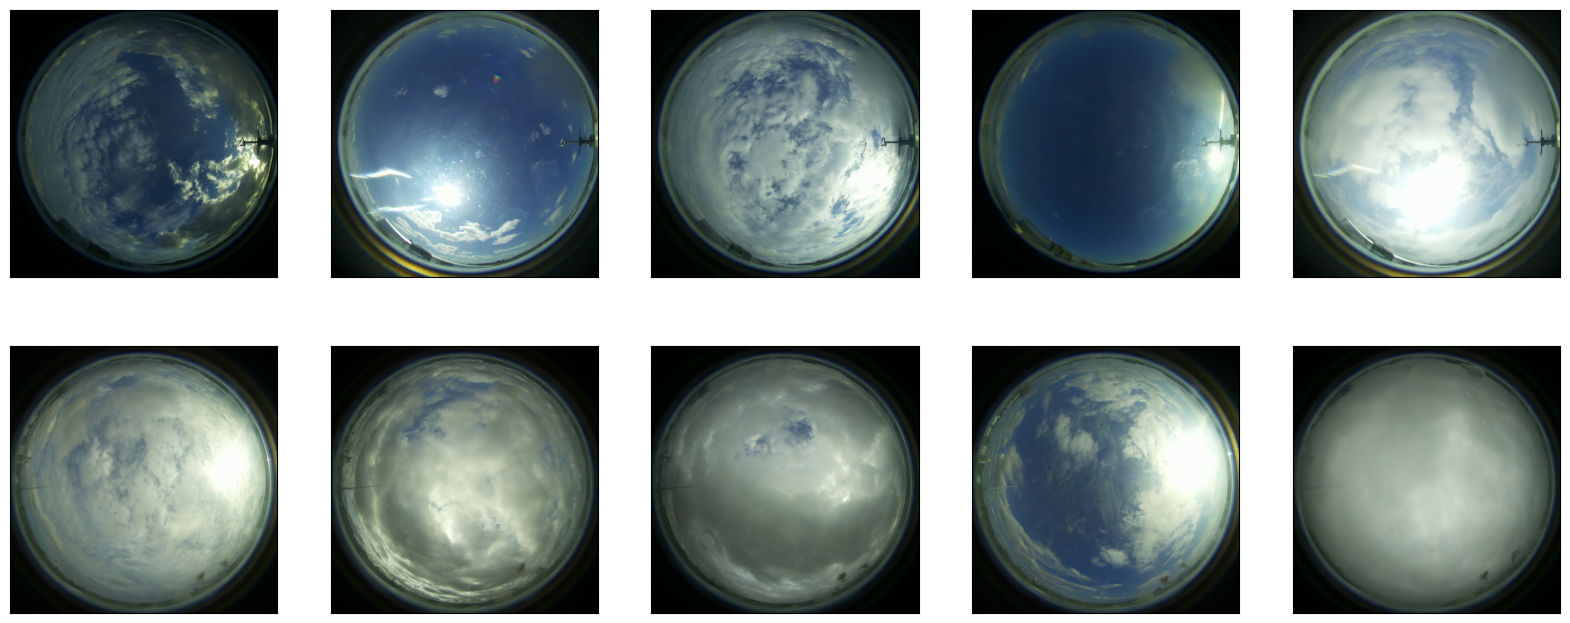

In [6]:
#Plot camera A (top row) and B (bottom row) images
#The images aren't matched up
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])
    
for i in range(5):
    n = np.random.randint(0,len(list(A_DPATH.glob('*.png'))))
    ax[0,i].imshow(plt.imread((list(A_DPATH.glob('*.png'))[n])))
    ax[1,i].imshow(plt.imread((list(B_DPATH.glob('*.png'))[n])))

### Camera Data Processing

In [3]:
#For each camera, create a list of all the filenames
A_filenames = []
B_filenames = []

for item in list(A_DPATH.glob('*.png')):
    #print(item.parts[-1])
    A_filenames.append(item.parts[-1])

for item in list(B_DPATH.glob('*.png')):
    #print(item.parts[-1])
    B_filenames.append(item.parts[-1])


In [4]:
#Find common filenames between the two cameras and create a list of those names
#Vast majority of images from each camera have a match

common = [item for item in A_filenames if item in B_filenames]
len(common)

13760

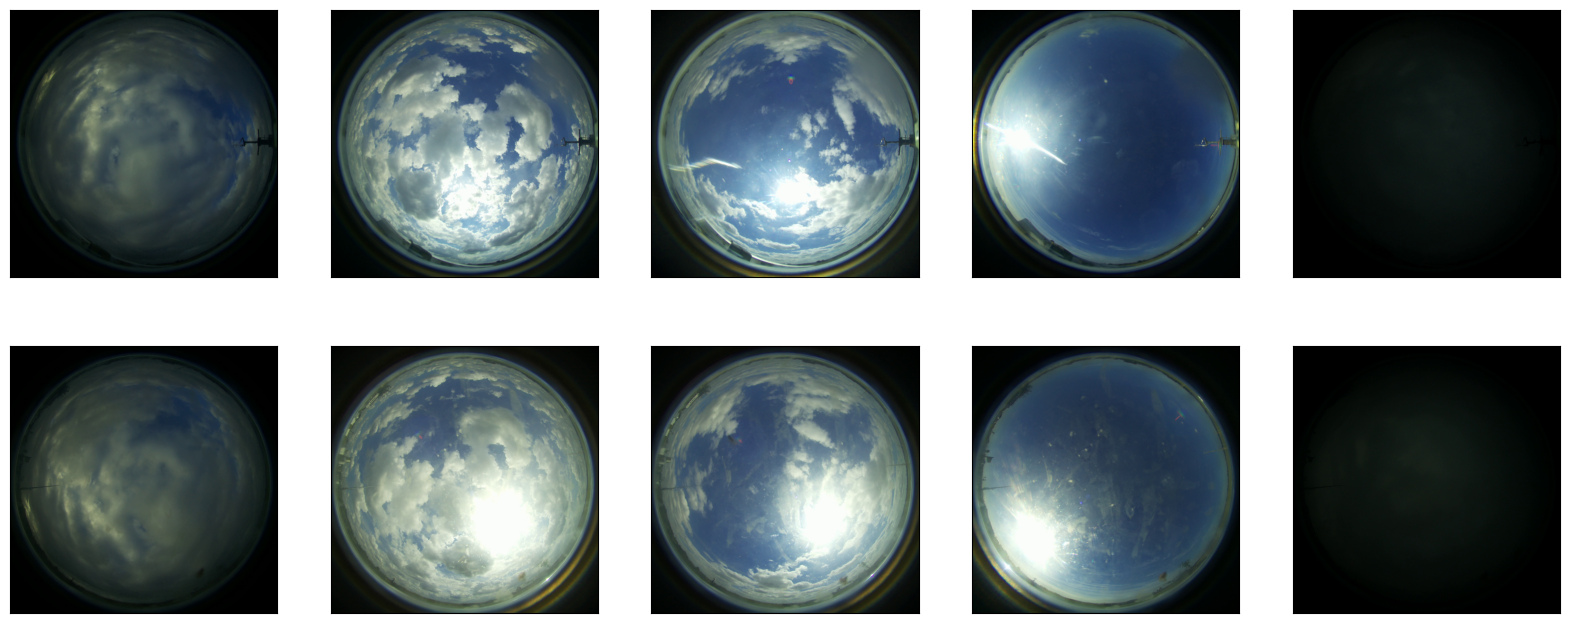

In [9]:
#Plot matched camera A (top row) and B (bottom row) images
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])
    
for i in range(5):
    n = np.random.randint(0,len(common))
    ax[0,i].imshow(plt.imread(A_DPATH / common[n]))
    ax[1,i].imshow(plt.imread(B_DPATH / common[n]))


In [5]:
#Extract the camera parameters
from fisheye_to_perspective_utils import extract_cube_map
import yaml

with open("/gws/nopw/j04/iecdt/computer-vision-data/fisheye_calib_A.yml", 'r') as f:
    calib_A = yaml.safe_load(f)

with open("/gws/nopw/j04/iecdt/computer-vision-data/fisheye_calib_B.yml", 'r') as f:
    calib_B = yaml.safe_load(f)

In [6]:
#Get rotations
transform = np.loadtxt('/gws/nopw/j04/iecdt/computer-vision-data/T_rel.txt')
transform

print(transform[0,0], np.rad2deg(np.arccos(transform[0,0])), np.rad2deg(np.arctan(transform[0,-1]/transform[1,-1])))

0.7325527461463054 42.89917114852312 -4.107031489484138


In [8]:
img_a = plt.imread(A_DPATH / common[0])

In [9]:
rectified_img_a = extract_cube_map(plt.imread(A_DPATH / common[0]), calib_A, rotate=-4.107031489484138)

tensor([[ 143.7343, 1396.9594],
        [1467.5994, 2925.6501],
        [2996.2900, 1601.7850],
        [1672.4250,   73.0942],
        [1570.0122, 1499.3722]])


/home/users/jordanc/iecdt-computer-vision-group-proj/.venv/lib/python3.12/site-packages/omnicalib/undistort/undistort.py:75: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:62.)
  down = unit(torch.cross(view, right))


In [16]:
img_a.shape

(768, 768, 3)

In [15]:
rectified_img_a[-1].shape

(3040, 3040, 3)

In [ ]:
(3040 * 3040) / (768 * 768)

15.668402777777779

tensor([[ 143.7343, 1396.9594],
        [1467.5994, 2925.6501],
        [2996.2900, 1601.7850],
        [1672.4250,   73.0942],
        [1570.0122, 1499.3722]])


/home/users/jordanc/iecdt-computer-vision-group-proj/.venv/lib/python3.12/site-packages/omnicalib/undistort/undistort.py:75: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:62.)
  down = unit(torch.cross(view, right))


tensor([[ 391.6121, 2451.5332],
        [2377.8687, 2667.5854],
        [2593.9209,  681.3287],
        [ 607.6642,  465.2765],
        [1492.7665, 1566.4309]])


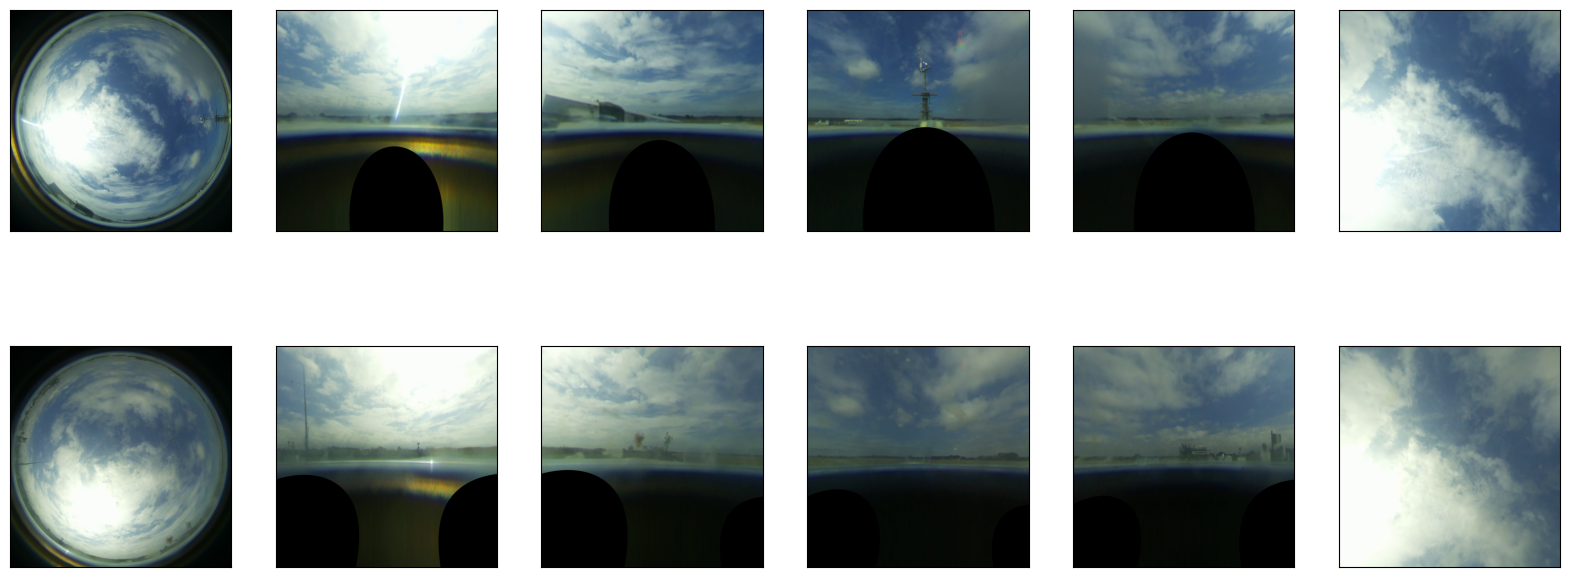

In [12]:
#Get an example image and plot the undistorted rotations for camera A (top row) and B (bottom row)

image_index = 2000

fig, ax = plt.subplots(2, 6, figsize=(20, 8))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])

#Camera A

img_a = extract_cube_map(plt.imread(A_DPATH / common[image_index]), calib_A, rotate=-4.107031489484138)

ax[0,0].imshow(plt.imread(A_DPATH / common[image_index]))
for i in range(0, 5):
    ax[0,i+1].imshow(img_a[i])

#Camera B

img_b = extract_cube_map(plt.imread(B_DPATH / common[image_index]), calib_B, rotate=42.89917114852312-4.107031489484138)

ax[1,0].imshow(plt.imread(B_DPATH / common[image_index]))
for i in range(0, 5):
    ax[1,i+1].imshow(img_b[i])

In [13]:
#Take all the images, process and save them

for i in range(len(common)):
    img_a = extract_cube_map(plt.imread(A_DPATH / common[i]), calib_A, rotate=-4.107031489484138)
    img_b = extract_cube_map(plt.imread(B_DPATH / common[i]), calib_B, rotate=42.89917114852312-4.107031489484138)
    plt.imsave(Path('dataset/cam_a/' + common[i]), img_a[-1])
    plt.imsave(Path('dataset/cam_b/' + common[i]), img_b[-1])
    print(i)


tensor([[ 143.7343, 1396.9594],
        [1467.5994, 2925.6501],
        [2996.2900, 1601.7850],
        [1672.4250,   73.0942],
        [1570.0122, 1499.3722]])
tensor([[ 391.6121, 2451.5332],
        [2377.8687, 2667.5854],
        [2593.9209,  681.3287],
        [ 607.6642,  465.2765],
        [1492.7665, 1566.4309]])
0
tensor([[ 143.7343, 1396.9594],
        [1467.5994, 2925.6501],
        [2996.2900, 1601.7850],
        [1672.4250,   73.0942],
        [1570.0122, 1499.3722]])
tensor([[ 391.6121, 2451.5332],
        [2377.8687, 2667.5854],
        [2593.9209,  681.3287],
        [ 607.6642,  465.2765],
        [1492.7665, 1566.4309]])
1
tensor([[ 143.7343, 1396.9594],
        [1467.5994, 2925.6501],
        [2996.2900, 1601.7850],
        [1672.4250,   73.0942],
        [1570.0122, 1499.3722]])
tensor([[ 391.6121, 2451.5332],
        [2377.8687, 2667.5854],
        [2593.9209,  681.3287],
        [ 607.6642,  465.2765],
        [1492.7665, 1566.4309]])
2
tensor([[ 143.7343, 1396.959

KeyboardInterrupt: 

### Check whether all files exist

In [13]:
#Camera A

directory_a = Path("/home/users/jordanc/iecdt-computer-vision-group-proj/dataset/cam_a")

file_paths_a = [directory_a / file for file in common]

files_a = 0
missing_files_a = []

for file in file_paths_a:
    if Path(file).exists():
        files_a += 1
    else:
        missing_files_a.append(file)

print(files_a, 'out of' , len(common), 'files found in cam_a')
print('Missing files:', len(missing_files_a))

8897 out of 13760 files found in cam_a
Missing files: 4863


In [19]:
A_DPATH / "../rectified_imgs"

PosixPath('/gws/nopw/j04/iecdt/computer-vision-data/cam_a/imgs/../rectified_imgs')

In [5]:
b_files = list((B_DPATH / "../rectified_imgs").glob('*.png'))
a_files = list((A_DPATH / "../rectified_imgs").glob('*.png'))

len(b_files), len(a_files)

(13760, 13760)

In [6]:
len(b_files), len(a_files)

(13760, 13760)

In [ ]:
#Camera B

directory_b = Path("/home/users/jordanc/iecdt-computer-vision-group-proj/dataset/cam_a")

file_paths_b = [directory_b / file for file in common]

files_b = 0
missing_files_b = []

for file in file_paths_b:
    if Path(file).exists():
        files_b += 1
    else:
        missing_files_b.append(file)

print(files_b, 'out of' , len(common), 'files found in cam_b')
print('Missing files:', len(missing_files_b))

8987 out of 13760 files found in cam_b
Missing files: 4773


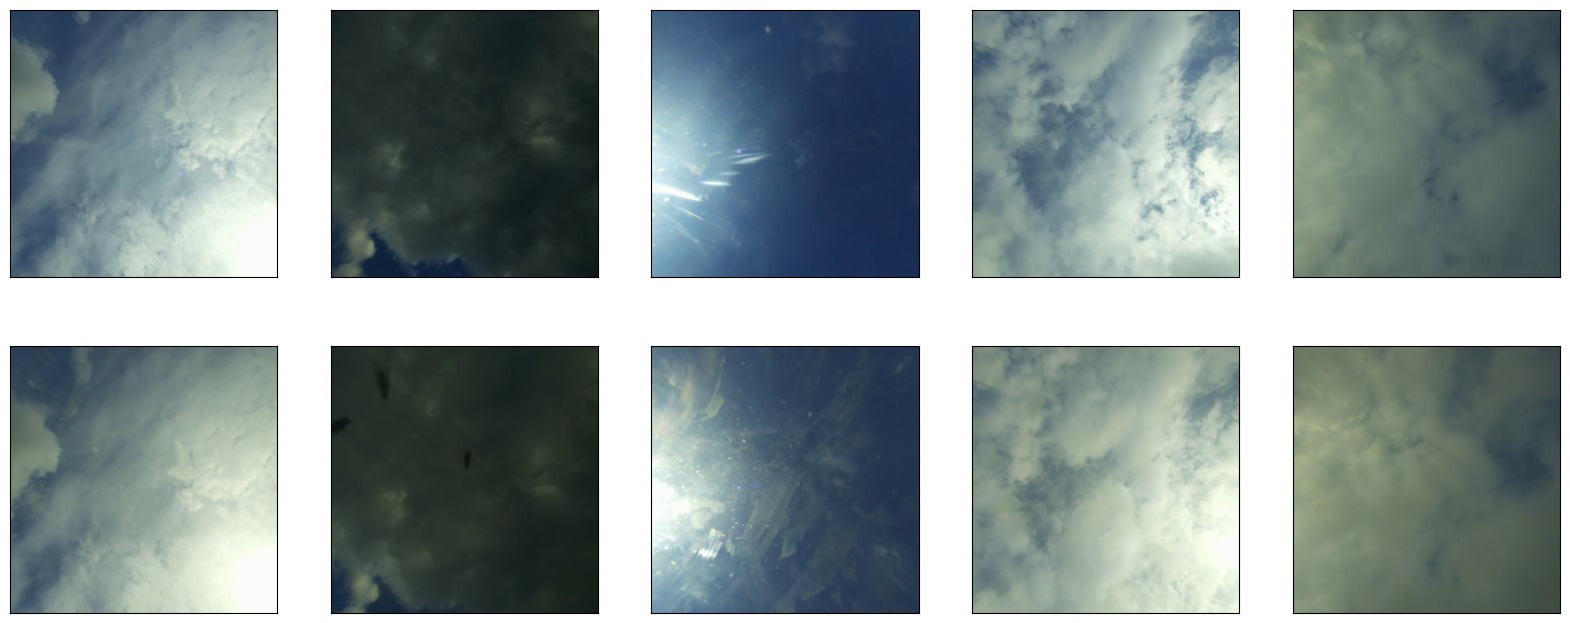

In [ ]:
#Plot some matched examples from the rectified images with camera A on top and camera B on the bottom
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])
for i in range(5):
    n = np.random.randint(0,13760)
    ax[0,i].imshow(plt.imread(list((A_DPATH / "../rectified_imgs").glob('*.png'))[n]))
    ax[1,i].imshow(plt.imread(list((B_DPATH / "../rectified_imgs").glob('*.png'))[n]))